In [2]:
# !pip install  matplotlib

In [1]:
from src import pnadc
import pandas as pd

In [2]:
metadata_filepath = pnadc.get_pnadc_metadata()
pnadc_filepath = pnadc.get_pnadc(ano=2021, trimestre=3)

2023-09-17 03:28:32.817 | INFO     | src.pnadc:_format_dict:74 - Importing data/dicionario_PNADC_microdados_trimestral.xls
2023-09-17 03:28:32.847 | INFO     | src.pnadc:_format_dict:88 - Filtering rows
2023-09-17 03:28:32.849 | INFO     | src.pnadc:_format_dict:100 - Exporting formatted dataset to data/pnadc_metadata.csv
2023-09-17 03:28:33.111 | INFO     | src.pnadc:get_pnadc:33 - Downloading data from PNADC from 'Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_continua/Trimestral/Microdados/2021/PNADC_032021_20220916.zip' and saving in 'data/PNADC_032021_20220916.zip'
2023-09-17 03:29:08.497 | INFO     | src.pnadc:get_pnadc:36 - Extracting data from 'data/PNADC_032021_20220916.zip' to 'data/PNADC_032021.txt'
2023-09-17 03:29:11.374 | INFO     | src.pnadc:get_pnadc:40 - Importing PNADC metadata
2023-09-17 03:29:11.376 | INFO     | src.pnadc:get_pnadc:43 - Reading PNADC dataframe from 'data/PNADC_032021.txt'
2023-09-17 03:30:26.456 | INFO     | src.pnadc:get_pnadc:48

In [3]:
metadata = pd.read_csv("data/pnadc_metadata.csv")

In [4]:
pnadc = pd.read_parquet("data/pnadc_032021.parquet")

In [11]:
pnadc.head()

codigo_da_variavel,Ano,Trimestre,UF,Capital,RM_RIDE,UPA,Estrato,V1008,V1014,V1016,...,V1028191,V1028192,V1028193,V1028194,V1028195,V1028196,V1028197,V1028198,V1028199,V1028200
0,2021,3,11,11.0,NaN,110000016,1110011,1,9,1,...,371.761638,418.473403,181.022922,199.25098,178.127877,181.654545,178.400546,170.24014,529.899895,0.0
1,2021,3,11,11.0,NaN,110000016,1110011,1,9,1,...,371.761638,418.473403,181.022922,199.25098,178.127877,181.654545,178.400546,170.24014,529.899895,0.0
2,2021,3,11,11.0,NaN,110000016,1110011,1,9,1,...,371.761638,418.473403,181.022922,199.25098,178.127877,181.654545,178.400546,170.24014,529.899895,0.0
3,2021,3,11,11.0,NaN,110000016,1110011,1,9,1,...,371.761638,418.473403,181.022922,199.25098,178.127877,181.654545,178.400546,170.24014,529.899895,0.0
4,2021,3,11,11.0,NaN,110000016,1110011,1,9,1,...,371.761638,418.473403,181.022922,199.25098,178.127877,181.654545,178.400546,170.24014,529.899895,0.0


In [13]:
pnadc["V2007"].value_counts()

V2007
2    224543
1    210279
Name: count, dtype: int64

<Axes: >

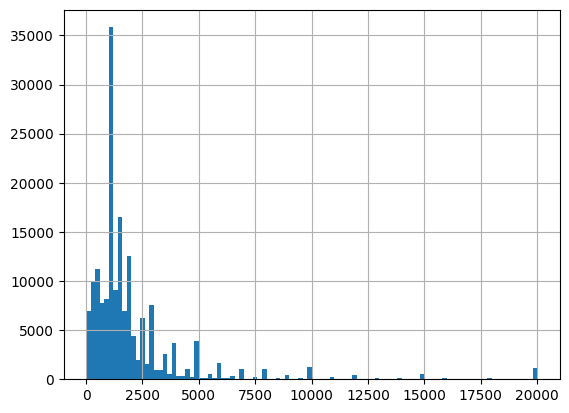

In [7]:
pnadc["VD4019"].clip(0,20000).hist(bins=100)

In [29]:
pnadc['e_capital'] = pnadc['Capital'].isna()

In [30]:
pnadc.groupby('e_capital').agg(
    salario = ("VD4019", "mean"),
)


,salario
e_capital,
False,3746.390963
True,2328.358666


# Development

In [7]:
import ftplib
import zipfile
import pandas as pd
from loguru import logger


HOST = "ftp.ibge.gov.br"
BASE_PATH = "Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_continua/Trimestral/Microdados"
DOCUMENTATION_DIR_PATH = f"{BASE_PATH}/Documentacao"
PNADC_RAW_METADATA_FILENAME = "dicionario_PNADC_microdados_trimestral.xls"
PNADC_FORMATED_METADATA_FILEPATH = "data/pnadc_metadata.csv"

DICT_INIT_ROW = 3

def get_pnadc_metadata():
    dict_ftp_filepath = _get_dict_filepath()
    dict_local_filepath = f"data/{dict_ftp_filepath}"
    _download_file(ftp_path=DOCUMENTATION_DIR_PATH, ftp_filename = dict_ftp_filepath, output_path=dict_local_filepath)
    zip_file = zipfile.ZipFile(dict_local_filepath)
    filename = zip_file.extract(PNADC_RAW_METADATA_FILENAME, path="data")
    _format_dict(filename, output_filepath=PNADC_FORMATED_METADATA_FILEPATH)


def get_pnadc(ano, trimestre):
    trimestre = str(int(trimestre)).zfill(2)
    
    zip_filename = f"PNADC_{trimestre}{ano}.zip"
    output_zip_filepath = f"data/{zip_filename}"
    txt_filename = zip_filename.replace("zip", "txt")
    
    logger.info(f"Downloading data from PNADC from '{BASE_PATH}/{ano}/{zip_filename}' and saving in '{output_zip_filepath}'")
    _download_file(f"{BASE_PATH}/{ano}", zip_filename, output_zip_filepath)
    
    logger.info(f"Extracting data from '{output_zip_filepath}' to 'data/{txt_filename}'")
    zip_file = zipfile.ZipFile(output_zip_filepath)
    pnadc_filepath = zip_file.extract(txt_filename, path="data")

    logger.info("Importing PNADC metadata")
    metadata = pd.read_csv(PNADC_FORMATED_METADATA_FILEPATH)
    
    logger.info(f"Reading PNADC dataframe from '{pnadc_filepath}'")
    pnadc = pd.read_fwf(pnadc_filepath, widths=metadata['tamanho'], header=None)
    pnadc.columns = metadata['codigo_da_variavel']

    pnadc_filename = f"data/pnadc_{trimestre}{ano}.csv"
    logger.info(f"Export PNADC dataframe to '{pnadc_filename}'")
    pnadc.to_csv(pnadc_filename, index=False)

    logger.info(f"PNADC microdata can be accessed in {pnadc_filename}")

    return pnadc_filename

def _get_dict_filepath():
    ftp = ftplib.FTP(HOST)
    ftp.login()
    ftp.cwd(DOCUMENTATION_DIR_PATH)
    dir_list = []
    ftp.dir(dir_list.append)
    return [f.split()[-1] for f in dir_list if "Dicionario_e_input" in f][0]


def _download_file(ftp_path, ftp_filename, output_path):
    ftp = ftplib.FTP(HOST)
    ftp.login()
    ftp.cwd(ftp_path)
    with open(output_path, 'wb') as file :
        ftp.retrbinary('RETR %s' % ftp_filename, file.write)
    ftp.close()


def _format_dict(dict_filepath, output_filepath = PNADC_FORMATED_METADATA_FILEPATH):
    logger.info(f"Importing {dict_filepath}")
    df = pd.read_excel(dict_filepath).iloc[DICT_INIT_ROW:]

    df.columns = [
        "posicao_incial",
        "tamanho",
        "codigo_da_variavel",
        "quesito_n", 
        "quesito_descricao",
        "categorias_tipo",
        "categorias_descricao",
        "periodo"
    ]

    logger.info(f"Filtering rows")

    def _is_number(x):
        try:
            number = int(x)
            return True
        except:
            return False
    
    variaveis = df[~df["posicao_incial"].isna()]
    variaveis = variaveis[variaveis['posicao_incial'].apply(_is_number)]
    
    logger.info(f"Exporting formatted dataset to {output_filepath}")
    variaveis.to_csv(output_filepath, index=False)


In [8]:
trimestre = 2
ano = 2023

get_pnadc_metadata()
pnadc_filename = get_pnadc(ano, trimestre)

2023-09-16 01:32:31.809 | INFO     | __main__:_format_dict:66 - Importing data/dicionario_PNADC_microdados_trimestral.xls
2023-09-16 01:32:31.840 | INFO     | __main__:_format_dict:80 - Filtering rows
2023-09-16 01:32:31.841 | INFO     | __main__:_format_dict:92 - Exporting formatted dataset to data/pnadc_metadata.csv
2023-09-16 01:32:31.845 | INFO     | __main__:get_pnadc:25 - Downloading data from PNADC from 'Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_continua/Trimestral/Microdados/2023/PNADC_022023.zip' and saving in 'data/PNADC_022023.zip'
2023-09-16 01:32:36.931 | INFO     | __main__:get_pnadc:28 - Extracting data from 'data/PNADC_022023.zip' to 'data/PNADC_022023.txt'
2023-09-16 01:32:43.944 | INFO     | __main__:get_pnadc:32 - Importing PNADC metadata
2023-09-16 01:32:43.956 | INFO     | __main__:get_pnadc:35 - Reading PNADC dataframe from 'data/PNADC_022023.txt'
2023-09-16 01:34:24.976 | INFO     | __main__:get_pnadc:40 - Export PNADC dataframe to 'data/p

In [220]:
%%time
pnadc_filepath = "data/PNADC_022023.txt"
pnadc = pd.read_fwf(pnadc_filepath, widths=metadata['tamanho'], header=None)
pnadc.columns = metadata['codigo_da_variavel']

CPU times: user 1min 35s, sys: 2.91 s, total: 1min 38s
Wall time: 1min 38s


In [207]:
zip_file.namelist()

['PNADC_022023.txt']

In [138]:
ftp = ftplib.FTP(HOST)
ftp.login()
ftp.cwd(BASE_PATH)

'250 Directory successfully changed.'

In [139]:
import zipfile

# zip file handler  
zip = zipfile.ZipFile('filename.zip')

# list available files in the container
print (zip.namelist())

# extract a specific file from the zip container
f = zip.open("file_inside_zip.txt")

# save the extraced file 
content = f.read()
f = open('file_inside_zip.extracted.txt', 'wb')
f.write(content)
f.close()


error_perm: 550 Failed to change directory.

In [136]:
ftp.cwd(BASE_PATH)

error_perm: 550 Failed to change directory.

In [132]:
_get_dict_filepath(ftp)

error_perm: 550 Failed to change directory.

In [129]:
ftp.pwd()


'/'

In [133]:
DOCUMENTATION_DIR_PATH

'Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_continua/Trimestral/Microdados/Documentacao'

'/Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_continua/Trimestral/Microdados/Documentacao'